In [2]:
# Ideas (SHORT TERM) :
#    0 / Industrialiser
#    1 / Check predictions et data en input (y chelou, faire des value_counts sur les y considérés, en tester plusieurs, etc.)
#    2 / Prendre fichier Excel et importer / valider data et créer features au fur et à mesure
#    3 / De temps en temps, reteter algos

#    Conseil Guyguy : avec quel proba les prédiction sont effectuées ? C'est assez sûr ?
#    Improve algos
#    Jouer sur ce qu'on prédit (+10, -10, etc.) + échéance !
#    Jouer sur le Treshold, si je prédit peu d'événements mais avec certitude, intéressant aussi !

In [ ]:
# GOAL : What am I searching for ?
        # => To predict with the best possible accuracy (proba) an event (+/- xx% variation of close_price)

# TODO : 
    # 1 / Testing phase + take ownership of the code
        # 1.1 / Test y_value and y_classif to be sure it's well calculated
        # 1.2 / Understand well what the code is doing end-to-end
    # 2 / Data vizualisation : Re-read MOOC + articles, what can I do ? Correlations, etc.
    # 3 / 
    
    # Try to optimize each algo at a time, see if I can use other algo   

In [1]:
from utils_csa import show_model_accuracy

import pandas.io.sql as psql
import pandas as pd
import numpy as np

from sqlalchemy import create_engine

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from pytz import timezone
from datetime import datetime, timedelta, date

from sklearn.model_selection import train_test_split

# Lib to calcul financial indicators https://github.com/mrjbq7/ta-lib
import talib

# Lib to import ipynb : https://pypi.org/project/import-ipynb/
import import_ipynb
import algocryptos_preprocessing as alg_preproc

importing Jupyter notebook from algocryptos_preprocessing.ipynb


In [65]:
# ------------------ PARAMETERS ------------------ #

# Choose y to be considered
# ['y_+6h_value', 'y_+6h_classif', 'y_+12h_value', 'y_+12h_classif',
#       'y_+1d_value', 'y_+1d_classif', 'y_+2d_value', 'y_+2d_classif',
#       'y_+3d_value', 'y_+3d_classif', 'y_+7d_value', 'y_+7d_classif',
#       'y_+15d_value', 'y_+15d_classif', 'y_+30d_value', 'y_+30d_classif']
id_cryptocompare = "7605" # ether
y_to_be_considered = 'y_+1d_classif'
close_price_increase_targeted = +10

In [3]:
# ------------------ DATA VIZUALISATION ------------------ #

# correlations (to be done with y to be searched, here not interesting...)
#print(df.close_price.corr(df.reddit_subscribers))
#print(df.close_price.corr(df.reddit_subscribers_slope))
#print(df.close_price.corr(df.volume_aggregated))
#print(df.close_price.corr(df.volume_aggregated_slope))

In [66]:
# ------------------ LOAD DATA FROM DATABASE ------------------ #
df2 = alg_preproc.get_global_dataset_for_crypto(id_cryptocompare)

# ------------------ PRE-PROCESSING : Splitting Data ------------------ #

# number of columns before adding y values
columns_nb = len(df2.columns)

def calcul_values_of_y(df, dict_hours_labels, increase_target_pct):
    increase_target_pct = increase_target_pct / 100
    
    for key in dict_hours_labels:
        label_value = 'y_+' + dict_hours_labels[key] + '_value'
        label_classif = 'y_+' + dict_hours_labels[key] + '_classif'
        # calcul several y searched (value)
        df[label_value] = df.close_price.shift(-key)
        
        # perform calcul to use binary classification
        df[label_classif] = ((df[label_value] - df['close_price']) / df['close_price']) > increase_target_pct
    
    return df

# calcul all y values we are interested in and add it to the dataframe
dict_hours_labels  = {6:'6h', 12:'12h', 24:'1d', 24*2:'2d', 24*3:'3d', 24*7:'7d', 24*15:'15d', 24*30:'30d'}
df3 = calcul_values_of_y(df2.copy(), dict_hours_labels, close_price_increase_targeted)

# remove rows where y can't be calculed (need more data in the future)
df3.dropna(subset=list(df3.iloc[:,range(columns_nb, len(df3.columns))]), inplace=True)

# separe x,y
X = df3.iloc[:,range(1, columns_nb)]
y = df3.iloc[:,range(columns_nb, len(df3.columns))]

# split data for training
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=False)

# ------------------ PRE-PROCESSING : Scaling Data ------------------ #
# scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [84]:
# search for correlations
for col in df3.columns.values:
    if df3[col].corr(df3['y_+1d_classif']) > 0.2:
        print(col + ' - ' + str(df3[col].corr(df3['y_+1d_classif'])))

last_period_high_low_price_var_pct - 0.24393807950590232
close_price_variance_7d_tether - 0.23241342386443337
close_price_variance_15d_tether - 0.24711846934699294
close_price_variance_30d_tether - 0.21595200436098552
open_price_bitcoin - 0.22867075177008753
high_price_bitcoin - 0.23073240504854228
low_price_bitcoin - 0.22599863653149513
close_price_bitcoin - 0.22905080710055628
close_price_variance_24h_bitcoin - 0.2507394288520406
close_price_variance_7d_bitcoin - 0.29909635492986797
close_price_variance_15d_bitcoin - 0.28516963845655335
close_price_variance_30d_bitcoin - 0.24407791280087143
last_period_high_low_price_var_pct_bitcoin - 0.2344394093201211
Indic_RSI_14d - 0.23137237911123065
Indic_EMA_30d_uptrend - 0.20192334267588496
Indic_RSI_sup_70 - 0.2143799333210739
reddit_subscribers_pct_change_1d - 0.32987393141019306
reddit_subscribers_pct_change_3d - 0.28785866379004255
reddit_subscribers_pct_change_7d - 0.28344253432856426
reddit_subscribers_pct_change_15d - 0.273540866463067

----------------------------------------------------------
Results for algorithm : MLPClassifier - Neural Network - Train
----------------------------------------------------------

Confusion Matrix :
 [[4532   16]
 [  27  287]]
Accuracy: 0.99
AUC: 0.96


Other Metrics :

             precision    recall  f1-score   support

      False       0.99      1.00      1.00      4548
       True       0.95      0.91      0.93       314

avg / total       0.99      0.99      0.99      4862

----------------------------------------------------------



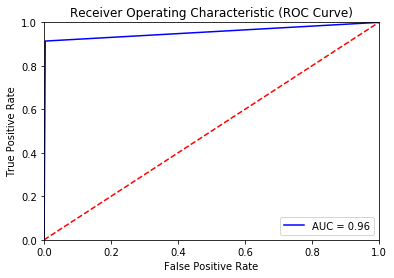

----------------------------------------------------------
Results for algorithm : MLPClassifier - Neural Network - Test
----------------------------------------------------------

Confusion Matrix :
 [[1573   37]
 [  11    0]]
Accuracy: 0.97
AUC: 0.49


Other Metrics :

             precision    recall  f1-score   support

      False       0.99      0.98      0.98      1610
       True       0.00      0.00      0.00        11

avg / total       0.99      0.97      0.98      1621

----------------------------------------------------------



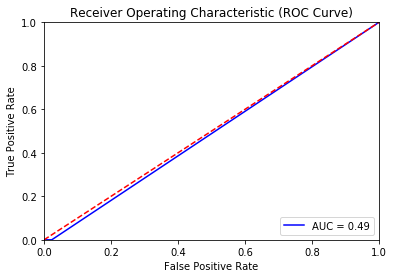

In [58]:
# -----------------------
# ALGO : MLPClassifier - Neural Network (cf. Module+4 for tuning)
# -----------------------
from sklearn.neural_network import MLPClassifier

nnclf = MLPClassifier(hidden_layer_sizes = [130, 130], solver='lbfgs',
                     random_state = 0).fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('MLPClassifier - Neural Network - Train', nnclf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('MLPClassifier - Neural Network - Test', nnclf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=False)

In [27]:
# ------------------ MODEL FITTING ------------------ #

# -----------------------
# ALGO : DUMMY CLASSIFIER
# -----------------------
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy = 'most_frequent').fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('DummyClassifier - Train', dummy_clf, X_train_scaled, y_train[y_to_be_considered], X_train.columns)
show_model_accuracy('DummyClassifier - Test', dummy_clf, X_test_scaled, y_test[y_to_be_considered], X_test.columns)

----------------------------------------------------------
Results for algorithm : DummyClassifier - Train
----------------------------------------------------------

Confusion Matrix :
 [[3896    0]
 [ 965    0]]
Accuracy: 0.80
AUC: 0.50


Other Metrics :

             precision    recall  f1-score   support

      False       0.80      1.00      0.89      3896
       True       0.00      0.00      0.00       965

avg / total       0.64      0.80      0.71      4861

----------------------------------------------------------

----------------------------------------------------------
Results for algorithm : DummyClassifier - Test
----------------------------------------------------------

Confusion Matrix :
 [[1483    0]
 [ 138    0]]
Accuracy: 0.91
AUC: 0.50


Other Metrics :

             precision    recall  f1-score   support

      False       0.91      1.00      0.96      1483
       True       0.00      0.00      0.00       138

avg / total       0.84      0.91      0.87      1

C:\Users\cysac\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


----------------------------------------------------------
Results for algorithm : RandomForestClassifier - Train
----------------------------------------------------------

Confusion Matrix :
 [[3270  626]
 [ 127  838]]
Accuracy: 0.85
AUC: 0.85


Other Metrics :

             precision    recall  f1-score   support

      False       0.96      0.84      0.90      3896
       True       0.57      0.87      0.69       965

avg / total       0.89      0.85      0.86      4861

----------------------------------------------------------



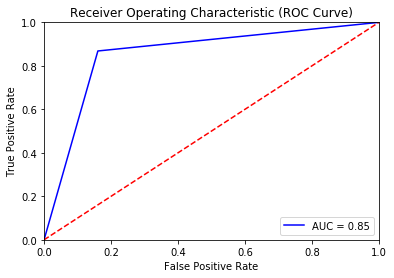

----------------------------------------------------------
Results for algorithm : RandomForestClassifier - Test
----------------------------------------------------------

Confusion Matrix :
 [[1483    0]
 [ 136    2]]
Accuracy: 0.92
AUC: 0.51


Other Metrics :

             precision    recall  f1-score   support

      False       0.92      1.00      0.96      1483
       True       1.00      0.01      0.03       138

avg / total       0.92      0.92      0.88      1621

----------------------------------------------------------



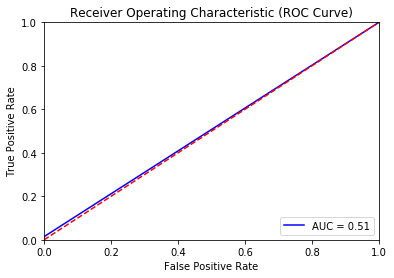

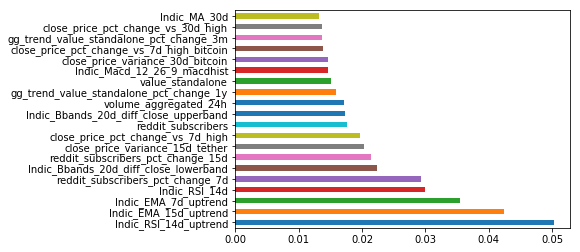

[0.18271757 0.18351294 0.24078933 ... 0.32611426 0.32737138 0.3332333 ]


In [28]:
# -----------------------
# ALGO : RANDOM FOREST
# -----------------------
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=250, random_state=0, max_features='auto', max_depth=4, class_weight="balanced").fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('RandomForestClassifier - Train', clf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('RandomForestClassifier - Test', clf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=True)

# proba : to be shown by prediction, bien comprendre !
print(clf.predict_proba(X_test_scaled)[:,1])

----------------------------------------------------------
Results for algorithm : NAIVE BAYES - GaussianNB - Train
----------------------------------------------------------

Confusion Matrix :
 [[2947   91]
 [ 124 1699]]
Accuracy: 0.96
AUC: 0.95


Other Metrics :

             precision    recall  f1-score   support

      False       0.96      0.97      0.96      3038
       True       0.95      0.93      0.94      1823

avg / total       0.96      0.96      0.96      4861

----------------------------------------------------------



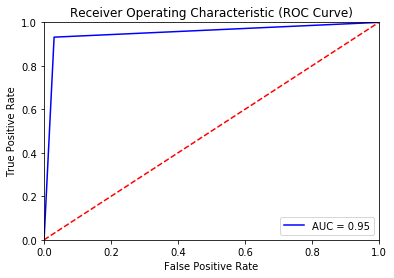

----------------------------------------------------------
Results for algorithm : NAIVE BAYES - GaussianNB - Test
----------------------------------------------------------

Confusion Matrix :
 [[   0 1327]
 [   0  294]]
Accuracy: 0.18
AUC: 0.50


Other Metrics :

             precision    recall  f1-score   support

      False       0.00      0.00      0.00      1327
       True       0.18      1.00      0.31       294

avg / total       0.03      0.18      0.06      1621

----------------------------------------------------------



C:\Users\cysac\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


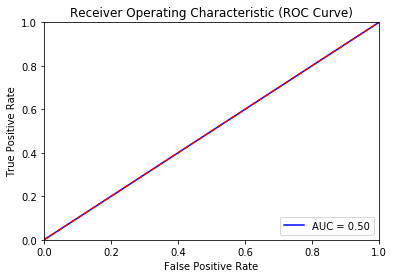

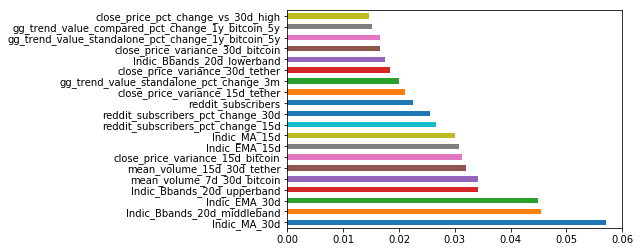

In [21]:
# -----------------------
# ALGO : NAIVE BAYES - GAUSSIANNB
# -----------------------
from sklearn.naive_bayes import GaussianNB

nbclf = GaussianNB().fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('NAIVE BAYES - GaussianNB - Train', clf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('NAIVE BAYES - GaussianNB - Test', clf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=True)


----------------------------------------------------------
Results for algorithm : GradientBoostingClassifier - Train
----------------------------------------------------------

Confusion Matrix :
 [[3877   19]
 [ 206  759]]
Accuracy: 0.95
AUC: 0.89


Other Metrics :

             precision    recall  f1-score   support

      False       0.95      1.00      0.97      3896
       True       0.98      0.79      0.87       965

avg / total       0.95      0.95      0.95      4861

----------------------------------------------------------



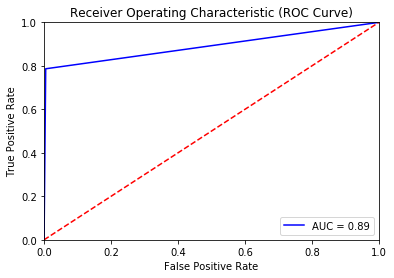

----------------------------------------------------------
Results for algorithm : GradientBoostingClassifier - Test
----------------------------------------------------------

Confusion Matrix :
 [[1326  157]
 [ 111   27]]
Accuracy: 0.83
AUC: 0.54


Other Metrics :

             precision    recall  f1-score   support

      False       0.92      0.89      0.91      1483
       True       0.15      0.20      0.17       138

avg / total       0.86      0.83      0.85      1621

----------------------------------------------------------



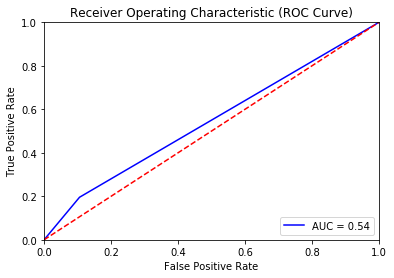

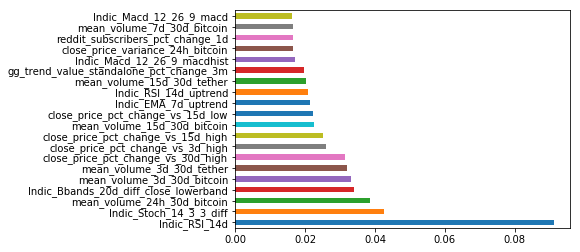

In [29]:
# -----------------------
# ALGO : GradientBoostingClassifier (cf. Module+4 for tuning)
# -----------------------
from sklearn.ensemble import GradientBoostingClassifier

#GradientBoostingClassifier(learning_rate = 0.02, max_depth = 5, random_state = 0)
clf = GradientBoostingClassifier().fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('GradientBoostingClassifier - Train', clf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('GradientBoostingClassifier - Test', clf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=True)

----------------------------------------------------------
Results for algorithm : SVM - Train
----------------------------------------------------------

Confusion Matrix :
 [[3778  118]
 [ 275  690]]
Accuracy: 0.92
AUC: 0.84


Other Metrics :

             precision    recall  f1-score   support

      False       0.93      0.97      0.95      3896
       True       0.85      0.72      0.78       965

avg / total       0.92      0.92      0.92      4861

----------------------------------------------------------



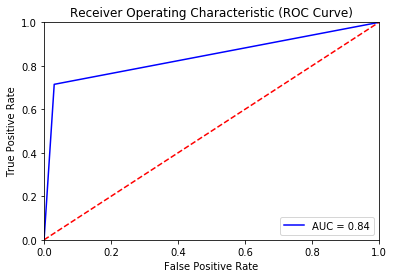

----------------------------------------------------------
Results for algorithm : SVM - Test
----------------------------------------------------------

Confusion Matrix :
 [[1293  190]
 [  99   39]]
Accuracy: 0.82
AUC: 0.58


Other Metrics :

             precision    recall  f1-score   support

      False       0.93      0.87      0.90      1483
       True       0.17      0.28      0.21       138

avg / total       0.86      0.82      0.84      1621

----------------------------------------------------------



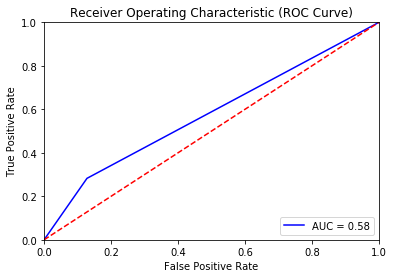

In [31]:
# -----------------------
# ALGO : SVC - (cf. Module+3 for tuning)
# -----------------------
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1).fit(X_train_scaled, y_train[y_to_be_considered])


show_model_accuracy('SVM - Train', svm, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('SVM - Test', svm, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=False)